In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from tqdm import tqdm
from backbone2 import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder
from torchsummary import summary
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cuda:1")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../data'

In [ ]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

384
384


In [ ]:
# Define model and optimizer
backbone = ResNet152d(num_classes=num_classes, embed_dim = 960)
model = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone)
model.to(device)

# Wrap your model with DataParallel
model = nn.DataParallel(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        # if a == 0: 
        #     print(labels)
        #     print(outputs)
        #     a=a+1
        

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric.update(outputs, labels,0)

    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")

    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)

            # Compute metrics on validation set
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels,1)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     

Epoch 1/200
----------


100%|██████████| 111/111 [01:47<00:00,  1.03it/s]


Epoch [1/200], Loss: 0.2762, ML mAP: 0.0796, ML F1: 0.0506, ML AUC: 0.4982, ML Score: 0.2889, Bin AUC: 0.3611, Model Score: 0.3250, Bin F1: 0.1176


100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


Val - Epoch [1/200], Loss: 0.2762, ML mAP: 0.0658, ML F1: 0.0000, ML AUC: 0.5283, ML Score: 0.2970, Bin AUC: 0.0526, Model Score: 0.1748, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


Epoch [2/200], Loss: 0.2422, ML mAP: 0.0857, ML F1: 0.0000, ML AUC: 0.5228, ML Score: 0.3042, Bin AUC: 0.7368, Model Score: 0.5205, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [2/200], Loss: 0.2422, ML mAP: 0.0854, ML F1: 0.0000, ML AUC: 0.5972, ML Score: 0.3413, Bin AUC: 0.1053, Model Score: 0.2233, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


Epoch [3/200], Loss: 0.2434, ML mAP: 0.1026, ML F1: 0.0000, ML AUC: 0.5710, ML Score: 0.3368, Bin AUC: 0.1579, Model Score: 0.2474, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Val - Epoch [3/200], Loss: 0.2434, ML mAP: 0.0869, ML F1: 0.0000, ML AUC: 0.6306, ML Score: 0.3588, Bin AUC: 0.0526, Model Score: 0.2057, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [4/200], Loss: 0.2936, ML mAP: 0.1266, ML F1: 0.0000, ML AUC: 0.6009, ML Score: 0.3637, Bin AUC: 0.7843, Model Score: 0.5740, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.60it/s]


Val - Epoch [4/200], Loss: 0.2936, ML mAP: 0.1100, ML F1: 0.0000, ML AUC: 0.6773, ML Score: 0.3936, Bin AUC: 0.3158, Model Score: 0.3547, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [5/200], Loss: 0.2595, ML mAP: 0.1342, ML F1: 0.0000, ML AUC: 0.6345, ML Score: 0.3844, Bin AUC: 0.4211, Model Score: 0.4027, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Val - Epoch [5/200], Loss: 0.2595, ML mAP: 0.1317, ML F1: 0.0000, ML AUC: 0.7176, ML Score: 0.4246, Bin AUC: 0.1053, Model Score: 0.2650, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [6/200], Loss: 0.3245, ML mAP: 0.1613, ML F1: 0.0000, ML AUC: 0.6746, ML Score: 0.4180, Bin AUC: 0.6111, Model Score: 0.5145, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.59it/s]


Val - Epoch [6/200], Loss: 0.3245, ML mAP: 0.1549, ML F1: 0.0000, ML AUC: 0.7453, ML Score: 0.4501, Bin AUC: 0.0000, Model Score: 0.2251, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [01:29<00:00,  1.24it/s]


Epoch [7/200], Loss: 0.3125, ML mAP: 0.1826, ML F1: 0.0000, ML AUC: 0.7048, ML Score: 0.4437, Bin AUC: 0.6316, Model Score: 0.5376, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [7/200], Loss: 0.3125, ML mAP: 0.1649, ML F1: 0.0000, ML AUC: 0.7660, ML Score: 0.4654, Bin AUC: 0.1053, Model Score: 0.2854, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [01:32<00:00,  1.19it/s]


Epoch [8/200], Loss: 0.2204, ML mAP: 0.1981, ML F1: 0.0000, ML AUC: 0.7253, ML Score: 0.4617, Bin AUC: 0.9474, Model Score: 0.7045, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


Val - Epoch [8/200], Loss: 0.2204, ML mAP: 0.1823, ML F1: 0.0000, ML AUC: 0.7794, ML Score: 0.4808, Bin AUC: 0.1579, Model Score: 0.3194, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [9/200], Loss: 0.3663, ML mAP: 0.1905, ML F1: 0.0000, ML AUC: 0.7249, ML Score: 0.4577, Bin AUC: 1.0000, Model Score: 0.7289, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Val - Epoch [9/200], Loss: 0.3663, ML mAP: 0.1831, ML F1: 0.0000, ML AUC: 0.7918, ML Score: 0.4874, Bin AUC: 0.3158, Model Score: 0.4016, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [10/200], Loss: 0.2528, ML mAP: 0.2064, ML F1: 0.0000, ML AUC: 0.7497, ML Score: 0.4780, Bin AUC: 0.9444, Model Score: 0.7112, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


Val - Epoch [10/200], Loss: 0.2528, ML mAP: 0.1918, ML F1: 0.0000, ML AUC: 0.8005, ML Score: 0.4962, Bin AUC: 0.3158, Model Score: 0.4060, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.22it/s]


Epoch [11/200], Loss: 0.2561, ML mAP: 0.2251, ML F1: 0.0000, ML AUC: 0.7599, ML Score: 0.4925, Bin AUC: 0.7895, Model Score: 0.6410, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [11/200], Loss: 0.2561, ML mAP: 0.2079, ML F1: 0.0000, ML AUC: 0.8083, ML Score: 0.5081, Bin AUC: 0.3158, Model Score: 0.4119, Bin F1: 0.0000

Epoch 12/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.21it/s]


Epoch [12/200], Loss: 0.3535, ML mAP: 0.2424, ML F1: 0.0026, ML AUC: 0.7687, ML Score: 0.5056, Bin AUC: 1.0000, Model Score: 0.7528, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Val - Epoch [12/200], Loss: 0.3535, ML mAP: 0.2167, ML F1: 0.0000, ML AUC: 0.8190, ML Score: 0.5178, Bin AUC: 0.4737, Model Score: 0.4958, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.21it/s]


Epoch [13/200], Loss: 0.2632, ML mAP: 0.2458, ML F1: 0.0086, ML AUC: 0.7804, ML Score: 0.5131, Bin AUC: 0.9474, Model Score: 0.7302, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Val - Epoch [13/200], Loss: 0.2632, ML mAP: 0.2317, ML F1: 0.0000, ML AUC: 0.8311, ML Score: 0.5314, Bin AUC: 0.4211, Model Score: 0.4762, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [01:29<00:00,  1.24it/s]


Epoch [14/200], Loss: 0.3518, ML mAP: 0.2561, ML F1: 0.0083, ML AUC: 0.7814, ML Score: 0.5187, Bin AUC: 0.6316, Model Score: 0.5752, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


Val - Epoch [14/200], Loss: 0.3518, ML mAP: 0.2407, ML F1: 0.0000, ML AUC: 0.8314, ML Score: 0.5360, Bin AUC: 0.4737, Model Score: 0.5049, Bin F1: 0.0000

Epoch 15/200
----------


100%|██████████| 111/111 [01:28<00:00,  1.25it/s]


Epoch [15/200], Loss: 0.2588, ML mAP: 0.2639, ML F1: 0.0143, ML AUC: 0.7932, ML Score: 0.5286, Bin AUC: 0.6842, Model Score: 0.6064, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Val - Epoch [15/200], Loss: 0.2588, ML mAP: 0.2673, ML F1: 0.0091, ML AUC: 0.8423, ML Score: 0.5548, Bin AUC: 0.6316, Model Score: 0.5932, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [16/200], Loss: 0.2789, ML mAP: 0.2731, ML F1: 0.0171, ML AUC: 0.7932, ML Score: 0.5331, Bin AUC: 0.9722, Model Score: 0.7527, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.56it/s]


Val - Epoch [16/200], Loss: 0.2789, ML mAP: 0.2641, ML F1: 0.0269, ML AUC: 0.8446, ML Score: 0.5544, Bin AUC: 0.5263, Model Score: 0.5404, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [01:32<00:00,  1.20it/s]


Epoch [17/200], Loss: 0.2415, ML mAP: 0.2942, ML F1: 0.0339, ML AUC: 0.8017, ML Score: 0.5480, Bin AUC: 1.0000, Model Score: 0.7740, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [17/200], Loss: 0.2415, ML mAP: 0.2662, ML F1: 0.0407, ML AUC: 0.8444, ML Score: 0.5553, Bin AUC: 0.4211, Model Score: 0.4882, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [01:30<00:00,  1.23it/s]


Epoch [18/200], Loss: 0.2559, ML mAP: 0.2858, ML F1: 0.0312, ML AUC: 0.8042, ML Score: 0.5450, Bin AUC: 0.8947, Model Score: 0.7199, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Val - Epoch [18/200], Loss: 0.2559, ML mAP: 0.2833, ML F1: 0.0400, ML AUC: 0.8531, ML Score: 0.5682, Bin AUC: 0.5263, Model Score: 0.5472, Bin F1: 0.0000

Epoch 19/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


Epoch [19/200], Loss: 0.2363, ML mAP: 0.3086, ML F1: 0.0517, ML AUC: 0.8082, ML Score: 0.5584, Bin AUC: 0.8611, Model Score: 0.7097, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [19/200], Loss: 0.2363, ML mAP: 0.2894, ML F1: 0.0283, ML AUC: 0.8509, ML Score: 0.5702, Bin AUC: 0.6842, Model Score: 0.6272, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


Epoch [20/200], Loss: 0.2938, ML mAP: 0.3106, ML F1: 0.0599, ML AUC: 0.8205, ML Score: 0.5656, Bin AUC: 0.6316, Model Score: 0.5986, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Val - Epoch [20/200], Loss: 0.2938, ML mAP: 0.3060, ML F1: 0.0775, ML AUC: 0.8590, ML Score: 0.5825, Bin AUC: 0.7368, Model Score: 0.6597, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


Epoch [21/200], Loss: 0.2687, ML mAP: 0.3137, ML F1: 0.0544, ML AUC: 0.8139, ML Score: 0.5638, Bin AUC: 0.4211, Model Score: 0.4924, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.51it/s]


Val - Epoch [21/200], Loss: 0.2687, ML mAP: 0.3082, ML F1: 0.0632, ML AUC: 0.8649, ML Score: 0.5866, Bin AUC: 0.6316, Model Score: 0.6091, Bin F1: 0.0000

Epoch 22/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


Epoch [22/200], Loss: 0.2807, ML mAP: 0.3478, ML F1: 0.0855, ML AUC: 0.8319, ML Score: 0.5898, Bin AUC: 0.9608, Model Score: 0.7753, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


Val - Epoch [22/200], Loss: 0.2807, ML mAP: 0.3172, ML F1: 0.0956, ML AUC: 0.8673, ML Score: 0.5922, Bin AUC: 0.8421, Model Score: 0.7172, Bin F1: 0.0000

Epoch 23/200
----------


100%|██████████| 111/111 [01:32<00:00,  1.20it/s]


Epoch [23/200], Loss: 0.2262, ML mAP: 0.3413, ML F1: 0.0839, ML AUC: 0.8253, ML Score: 0.5833, Bin AUC: 1.0000, Model Score: 0.7917, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Val - Epoch [23/200], Loss: 0.2262, ML mAP: 0.3155, ML F1: 0.1234, ML AUC: 0.8678, ML Score: 0.5916, Bin AUC: 0.6842, Model Score: 0.6379, Bin F1: 0.0000

Epoch 24/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.21it/s]


Epoch [24/200], Loss: 0.2745, ML mAP: 0.3512, ML F1: 0.0881, ML AUC: 0.8327, ML Score: 0.5920, Bin AUC: 1.0000, Model Score: 0.7960, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


Val - Epoch [24/200], Loss: 0.2745, ML mAP: 0.3246, ML F1: 0.1359, ML AUC: 0.8723, ML Score: 0.5984, Bin AUC: 0.6316, Model Score: 0.6150, Bin F1: 0.0000

Epoch 25/200
----------


100%|██████████| 111/111 [01:32<00:00,  1.20it/s]


Epoch [25/200], Loss: 0.2660, ML mAP: 0.3538, ML F1: 0.0866, ML AUC: 0.8351, ML Score: 0.5944, Bin AUC: 1.0000, Model Score: 0.7972, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Val - Epoch [25/200], Loss: 0.2660, ML mAP: 0.3268, ML F1: 0.1206, ML AUC: 0.8701, ML Score: 0.5984, Bin AUC: 0.6316, Model Score: 0.6150, Bin F1: 0.0000

Epoch 26/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.19it/s]


Epoch [26/200], Loss: 0.2314, ML mAP: 0.3721, ML F1: 0.1215, ML AUC: 0.8433, ML Score: 0.6077, Bin AUC: 0.9722, Model Score: 0.7900, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Val - Epoch [26/200], Loss: 0.2314, ML mAP: 0.3280, ML F1: 0.1516, ML AUC: 0.8665, ML Score: 0.5973, Bin AUC: 0.6316, Model Score: 0.6144, Bin F1: 0.0000

Epoch 27/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


Epoch [27/200], Loss: 0.2614, ML mAP: 0.3747, ML F1: 0.1290, ML AUC: 0.8375, ML Score: 0.6061, Bin AUC: 0.8947, Model Score: 0.7504, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


Val - Epoch [27/200], Loss: 0.2614, ML mAP: 0.3372, ML F1: 0.1556, ML AUC: 0.8692, ML Score: 0.6032, Bin AUC: 0.6842, Model Score: 0.6437, Bin F1: 0.0000

Epoch 28/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.22it/s]


Epoch [28/200], Loss: 0.2406, ML mAP: 0.3858, ML F1: 0.1255, ML AUC: 0.8521, ML Score: 0.6189, Bin AUC: 1.0000, Model Score: 0.8095, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


Val - Epoch [28/200], Loss: 0.2406, ML mAP: 0.3488, ML F1: 0.1509, ML AUC: 0.8729, ML Score: 0.6108, Bin AUC: 0.7368, Model Score: 0.6738, Bin F1: 0.0000

Epoch 29/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.22it/s]


Epoch [29/200], Loss: 0.2897, ML mAP: 0.3782, ML F1: 0.1441, ML AUC: 0.8448, ML Score: 0.6115, Bin AUC: 0.9474, Model Score: 0.7794, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.53it/s]


Val - Epoch [29/200], Loss: 0.2897, ML mAP: 0.3454, ML F1: 0.1628, ML AUC: 0.8703, ML Score: 0.6078, Bin AUC: 0.6316, Model Score: 0.6197, Bin F1: 0.0000

Epoch 30/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


Epoch [30/200], Loss: 0.2506, ML mAP: 0.4007, ML F1: 0.1565, ML AUC: 0.8497, ML Score: 0.6252, Bin AUC: 1.0000, Model Score: 0.8126, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.52it/s]


Val - Epoch [30/200], Loss: 0.2506, ML mAP: 0.3650, ML F1: 0.1685, ML AUC: 0.8748, ML Score: 0.6199, Bin AUC: 0.7368, Model Score: 0.6784, Bin F1: 0.0000

Epoch 31/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.22it/s]


Epoch [31/200], Loss: 0.3044, ML mAP: 0.4050, ML F1: 0.1632, ML AUC: 0.8581, ML Score: 0.6315, Bin AUC: 1.0000, Model Score: 0.8158, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Val - Epoch [31/200], Loss: 0.3044, ML mAP: 0.3686, ML F1: 0.1843, ML AUC: 0.8798, ML Score: 0.6242, Bin AUC: 0.7895, Model Score: 0.7068, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [01:31<00:00,  1.21it/s]


Epoch [32/200], Loss: 0.3212, ML mAP: 0.4163, ML F1: 0.1711, ML AUC: 0.8567, ML Score: 0.6365, Bin AUC: 0.6842, Model Score: 0.6604, Bin F1: 0.0000


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


Val - Epoch [32/200], Loss: 0.3212, ML mAP: 0.3565, ML F1: 0.1717, ML AUC: 0.8772, ML Score: 0.6168, Bin AUC: 0.7368, Model Score: 0.6768, Bin F1: 0.0000

Epoch 33/200
----------


100%|██████████| 111/111 [01:29<00:00,  1.25it/s]


Epoch [33/200], Loss: 0.2864, ML mAP: 0.4180, ML F1: 0.1753, ML AUC: 0.8619, ML Score: 0.6400, Bin AUC: 0.8947, Model Score: 0.7673, Bin F1: 0.0000


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Val - Epoch [33/200], Loss: 0.2864, ML mAP: 0.3426, ML F1: 0.1768, ML AUC: 0.8806, ML Score: 0.6116, Bin AUC: 0.6842, Model Score: 0.6479, Bin F1: 0.0000

Epoch 34/200
----------


100%|██████████| 111/111 [01:29<00:00,  1.24it/s]


Epoch [34/200], Loss: 0.3467, ML mAP: 0.4134, ML F1: 0.1788, ML AUC: 0.8618, ML Score: 0.6376, Bin AUC: 1.0000, Model Score: 0.8188, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [34/200], Loss: 0.3467, ML mAP: 0.3506, ML F1: 0.1970, ML AUC: 0.8740, ML Score: 0.6123, Bin AUC: 0.8421, Model Score: 0.7272, Bin F1: 0.0000

Epoch 35/200
----------


100%|██████████| 111/111 [01:28<00:00,  1.26it/s]


Epoch [35/200], Loss: 0.1778, ML mAP: 0.4373, ML F1: 0.2095, ML AUC: 0.8633, ML Score: 0.6503, Bin AUC: 0.8889, Model Score: 0.7696, Bin F1: 0.0000


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]


Val - Epoch [35/200], Loss: 0.1778, ML mAP: 0.3549, ML F1: 0.2031, ML AUC: 0.8759, ML Score: 0.6154, Bin AUC: 0.8421, Model Score: 0.7287, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [01:27<00:00,  1.26it/s]


Epoch [36/200], Loss: 0.3057, ML mAP: 0.4273, ML F1: 0.2071, ML AUC: 0.8617, ML Score: 0.6445, Bin AUC: 1.0000, Model Score: 0.8222, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [36/200], Loss: 0.3057, ML mAP: 0.3811, ML F1: 0.2420, ML AUC: 0.8838, ML Score: 0.6324, Bin AUC: 0.7895, Model Score: 0.7110, Bin F1: 0.0000

Epoch 37/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.57it/s]


Epoch [37/200], Loss: 0.2350, ML mAP: 0.4321, ML F1: 0.2101, ML AUC: 0.8677, ML Score: 0.6499, Bin AUC: 1.0000, Model Score: 0.8249, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [37/200], Loss: 0.2350, ML mAP: 0.3700, ML F1: 0.2188, ML AUC: 0.8757, ML Score: 0.6229, Bin AUC: 0.7368, Model Score: 0.6798, Bin F1: 0.0000

Epoch 38/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.60it/s]


Epoch [38/200], Loss: 0.2590, ML mAP: 0.4401, ML F1: 0.2179, ML AUC: 0.8663, ML Score: 0.6532, Bin AUC: 0.8611, Model Score: 0.7572, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [38/200], Loss: 0.2590, ML mAP: 0.3758, ML F1: 0.2115, ML AUC: 0.8847, ML Score: 0.6303, Bin AUC: 0.7895, Model Score: 0.7099, Bin F1: 0.0000

Epoch 39/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [39/200], Loss: 0.2585, ML mAP: 0.4317, ML F1: 0.2131, ML AUC: 0.8646, ML Score: 0.6482, Bin AUC: 0.8421, Model Score: 0.7451, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [39/200], Loss: 0.2585, ML mAP: 0.3784, ML F1: 0.2243, ML AUC: 0.8837, ML Score: 0.6311, Bin AUC: 0.7895, Model Score: 0.7103, Bin F1: 0.0000

Epoch 40/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [40/200], Loss: 0.2577, ML mAP: 0.4555, ML F1: 0.2417, ML AUC: 0.8737, ML Score: 0.6646, Bin AUC: 1.0000, Model Score: 0.8323, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [40/200], Loss: 0.2577, ML mAP: 0.3922, ML F1: 0.2132, ML AUC: 0.8835, ML Score: 0.6378, Bin AUC: 0.7895, Model Score: 0.7137, Bin F1: 0.0000

Epoch 41/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [41/200], Loss: 0.2256, ML mAP: 0.4637, ML F1: 0.2565, ML AUC: 0.8743, ML Score: 0.6690, Bin AUC: 0.9722, Model Score: 0.8206, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [41/200], Loss: 0.2256, ML mAP: 0.3716, ML F1: 0.2173, ML AUC: 0.8818, ML Score: 0.6267, Bin AUC: 0.8947, Model Score: 0.7607, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Epoch [42/200], Loss: 0.1938, ML mAP: 0.4597, ML F1: 0.2445, ML AUC: 0.8741, ML Score: 0.6669, Bin AUC: 0.9722, Model Score: 0.8196, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [42/200], Loss: 0.1938, ML mAP: 0.3911, ML F1: 0.2260, ML AUC: 0.8828, ML Score: 0.6370, Bin AUC: 0.7895, Model Score: 0.7132, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [43/200], Loss: 0.2492, ML mAP: 0.4764, ML F1: 0.2692, ML AUC: 0.8810, ML Score: 0.6787, Bin AUC: 0.9722, Model Score: 0.8255, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [43/200], Loss: 0.2492, ML mAP: 0.3834, ML F1: 0.2229, ML AUC: 0.8887, ML Score: 0.6361, Bin AUC: 0.7895, Model Score: 0.7128, Bin F1: 0.0000

Epoch 44/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [44/200], Loss: 0.2174, ML mAP: 0.4678, ML F1: 0.2686, ML AUC: 0.8758, ML Score: 0.6718, Bin AUC: 0.5000, Model Score: 0.5859, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [44/200], Loss: 0.2174, ML mAP: 0.3935, ML F1: 0.2424, ML AUC: 0.8832, ML Score: 0.6384, Bin AUC: 0.7895, Model Score: 0.7139, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [45/200], Loss: 0.2280, ML mAP: 0.4749, ML F1: 0.2718, ML AUC: 0.8822, ML Score: 0.6786, Bin AUC: 1.0000, Model Score: 0.8393, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [45/200], Loss: 0.2280, ML mAP: 0.3947, ML F1: 0.2362, ML AUC: 0.8879, ML Score: 0.6413, Bin AUC: 0.7895, Model Score: 0.7154, Bin F1: 0.0000

Epoch 46/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [46/200], Loss: 0.2234, ML mAP: 0.4927, ML F1: 0.2873, ML AUC: 0.8891, ML Score: 0.6909, Bin AUC: 0.8125, Model Score: 0.7517, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [46/200], Loss: 0.2234, ML mAP: 0.3999, ML F1: 0.2440, ML AUC: 0.8916, ML Score: 0.6457, Bin AUC: 0.7895, Model Score: 0.7176, Bin F1: 0.0000

Epoch 47/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [47/200], Loss: 0.2409, ML mAP: 0.4847, ML F1: 0.2779, ML AUC: 0.8860, ML Score: 0.6854, Bin AUC: 0.7368, Model Score: 0.7111, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [47/200], Loss: 0.2409, ML mAP: 0.4050, ML F1: 0.2597, ML AUC: 0.8893, ML Score: 0.6472, Bin AUC: 0.8421, Model Score: 0.7446, Bin F1: 0.0000

Epoch 48/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [48/200], Loss: 0.3574, ML mAP: 0.4911, ML F1: 0.2844, ML AUC: 0.8834, ML Score: 0.6872, Bin AUC: 0.8235, Model Score: 0.7554, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [48/200], Loss: 0.3574, ML mAP: 0.4007, ML F1: 0.2500, ML AUC: 0.8849, ML Score: 0.6428, Bin AUC: 0.7895, Model Score: 0.7161, Bin F1: 0.0000

Epoch 49/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch [49/200], Loss: 0.3450, ML mAP: 0.4928, ML F1: 0.3016, ML AUC: 0.8825, ML Score: 0.6876, Bin AUC: 0.8611, Model Score: 0.7744, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [49/200], Loss: 0.3450, ML mAP: 0.4000, ML F1: 0.2646, ML AUC: 0.8860, ML Score: 0.6430, Bin AUC: 0.7895, Model Score: 0.7162, Bin F1: 0.0000

Epoch 50/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [50/200], Loss: 0.2424, ML mAP: 0.5101, ML F1: 0.3036, ML AUC: 0.8914, ML Score: 0.7007, Bin AUC: 0.9167, Model Score: 0.8087, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [50/200], Loss: 0.2424, ML mAP: 0.4079, ML F1: 0.2507, ML AUC: 0.8895, ML Score: 0.6487, Bin AUC: 0.9474, Model Score: 0.7980, Bin F1: 0.0000

Epoch 51/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [51/200], Loss: 0.1847, ML mAP: 0.5079, ML F1: 0.3176, ML AUC: 0.8908, ML Score: 0.6993, Bin AUC: 0.9216, Model Score: 0.8105, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [51/200], Loss: 0.1847, ML mAP: 0.4084, ML F1: 0.2909, ML AUC: 0.8923, ML Score: 0.6503, Bin AUC: 0.7895, Model Score: 0.7199, Bin F1: 0.0000

Epoch 52/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch [52/200], Loss: 0.3404, ML mAP: 0.5091, ML F1: 0.3200, ML AUC: 0.8916, ML Score: 0.7003, Bin AUC: 0.8421, Model Score: 0.7712, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [52/200], Loss: 0.3404, ML mAP: 0.4079, ML F1: 0.2770, ML AUC: 0.8951, ML Score: 0.6515, Bin AUC: 0.8421, Model Score: 0.7468, Bin F1: 0.0000

Epoch 53/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [53/200], Loss: 0.1699, ML mAP: 0.5035, ML F1: 0.3263, ML AUC: 0.8886, ML Score: 0.6960, Bin AUC: 0.9804, Model Score: 0.8382, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [53/200], Loss: 0.1699, ML mAP: 0.4113, ML F1: 0.2826, ML AUC: 0.8909, ML Score: 0.6511, Bin AUC: 0.8421, Model Score: 0.7466, Bin F1: 0.0000

Epoch 54/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [54/200], Loss: 0.1944, ML mAP: 0.5207, ML F1: 0.3164, ML AUC: 0.8961, ML Score: 0.7084, Bin AUC: 1.0000, Model Score: 0.8542, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [54/200], Loss: 0.1944, ML mAP: 0.4225, ML F1: 0.2829, ML AUC: 0.8985, ML Score: 0.6605, Bin AUC: 0.8947, Model Score: 0.7776, Bin F1: 0.0000

Epoch 55/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Epoch [55/200], Loss: 0.2271, ML mAP: 0.5311, ML F1: 0.3384, ML AUC: 0.8991, ML Score: 0.7151, Bin AUC: 0.8421, Model Score: 0.7786, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [55/200], Loss: 0.2271, ML mAP: 0.4110, ML F1: 0.2589, ML AUC: 0.8953, ML Score: 0.6532, Bin AUC: 0.8947, Model Score: 0.7739, Bin F1: 0.0000

Epoch 56/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Epoch [56/200], Loss: 0.1671, ML mAP: 0.5339, ML F1: 0.3355, ML AUC: 0.8969, ML Score: 0.7154, Bin AUC: 1.0000, Model Score: 0.8577, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [56/200], Loss: 0.1671, ML mAP: 0.4174, ML F1: 0.2678, ML AUC: 0.8963, ML Score: 0.6568, Bin AUC: 0.8947, Model Score: 0.7758, Bin F1: 0.0000

Epoch 57/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Epoch [57/200], Loss: 0.2163, ML mAP: 0.5364, ML F1: 0.3355, ML AUC: 0.9017, ML Score: 0.7190, Bin AUC: 1.0000, Model Score: 0.8595, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [57/200], Loss: 0.2163, ML mAP: 0.4300, ML F1: 0.3378, ML AUC: 0.8984, ML Score: 0.6642, Bin AUC: 0.6842, Model Score: 0.6742, Bin F1: 0.0000

Epoch 58/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.79it/s]


Epoch [58/200], Loss: 0.2982, ML mAP: 0.5258, ML F1: 0.3502, ML AUC: 0.8970, ML Score: 0.7114, Bin AUC: 0.6316, Model Score: 0.6715, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [58/200], Loss: 0.2982, ML mAP: 0.4158, ML F1: 0.2901, ML AUC: 0.8946, ML Score: 0.6552, Bin AUC: 0.8421, Model Score: 0.7486, Bin F1: 0.0000

Epoch 59/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [59/200], Loss: 0.2477, ML mAP: 0.5477, ML F1: 0.3624, ML AUC: 0.9051, ML Score: 0.7264, Bin AUC: 0.9167, Model Score: 0.8215, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [59/200], Loss: 0.2477, ML mAP: 0.4278, ML F1: 0.2869, ML AUC: 0.8948, ML Score: 0.6613, Bin AUC: 0.8947, Model Score: 0.7780, Bin F1: 0.0000

Epoch 60/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [60/200], Loss: 0.2250, ML mAP: 0.5510, ML F1: 0.3667, ML AUC: 0.9043, ML Score: 0.7277, Bin AUC: 0.9608, Model Score: 0.8442, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [60/200], Loss: 0.2250, ML mAP: 0.4237, ML F1: 0.3030, ML AUC: 0.8922, ML Score: 0.6579, Bin AUC: 0.8947, Model Score: 0.7763, Bin F1: 0.0000

Epoch 61/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [61/200], Loss: 0.2393, ML mAP: 0.5291, ML F1: 0.3401, ML AUC: 0.8994, ML Score: 0.7143, Bin AUC: 1.0000, Model Score: 0.8571, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [61/200], Loss: 0.2393, ML mAP: 0.4261, ML F1: 0.2852, ML AUC: 0.8969, ML Score: 0.6615, Bin AUC: 0.8947, Model Score: 0.7781, Bin F1: 0.0000

Epoch 62/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [62/200], Loss: 0.2454, ML mAP: 0.5450, ML F1: 0.3560, ML AUC: 0.8998, ML Score: 0.7224, Bin AUC: 0.9722, Model Score: 0.8473, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [62/200], Loss: 0.2454, ML mAP: 0.4347, ML F1: 0.2916, ML AUC: 0.8968, ML Score: 0.6658, Bin AUC: 0.8947, Model Score: 0.7803, Bin F1: 0.0000

Epoch 63/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [63/200], Loss: 0.1980, ML mAP: 0.5530, ML F1: 0.3654, ML AUC: 0.9085, ML Score: 0.7307, Bin AUC: 1.0000, Model Score: 0.8654, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [63/200], Loss: 0.1980, ML mAP: 0.4283, ML F1: 0.2787, ML AUC: 0.8967, ML Score: 0.6625, Bin AUC: 0.8947, Model Score: 0.7786, Bin F1: 0.0000

Epoch 64/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [64/200], Loss: 0.2030, ML mAP: 0.5434, ML F1: 0.3693, ML AUC: 0.9040, ML Score: 0.7237, Bin AUC: 0.6667, Model Score: 0.6952, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [64/200], Loss: 0.2030, ML mAP: 0.4498, ML F1: 0.3344, ML AUC: 0.8994, ML Score: 0.6746, Bin AUC: 0.8947, Model Score: 0.7847, Bin F1: 0.0000

Epoch 65/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [65/200], Loss: 0.2150, ML mAP: 0.5763, ML F1: 0.3829, ML AUC: 0.9101, ML Score: 0.7432, Bin AUC: 1.0000, Model Score: 0.8716, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [65/200], Loss: 0.2150, ML mAP: 0.4337, ML F1: 0.3085, ML AUC: 0.8947, ML Score: 0.6642, Bin AUC: 0.8947, Model Score: 0.7795, Bin F1: 0.0000

Epoch 66/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [66/200], Loss: 0.2079, ML mAP: 0.5620, ML F1: 0.3881, ML AUC: 0.9073, ML Score: 0.7347, Bin AUC: 1.0000, Model Score: 0.8673, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [66/200], Loss: 0.2079, ML mAP: 0.4305, ML F1: 0.3025, ML AUC: 0.8959, ML Score: 0.6632, Bin AUC: 0.8947, Model Score: 0.7789, Bin F1: 0.0000

Epoch 67/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [67/200], Loss: 0.2397, ML mAP: 0.5746, ML F1: 0.3923, ML AUC: 0.9064, ML Score: 0.7405, Bin AUC: 0.9722, Model Score: 0.8564, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [67/200], Loss: 0.2397, ML mAP: 0.4447, ML F1: 0.3154, ML AUC: 0.9007, ML Score: 0.6727, Bin AUC: 0.9474, Model Score: 0.8101, Bin F1: 0.0000

Epoch 68/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [68/200], Loss: 0.1925, ML mAP: 0.5784, ML F1: 0.3879, ML AUC: 0.9097, ML Score: 0.7441, Bin AUC: 0.9474, Model Score: 0.8457, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [68/200], Loss: 0.1925, ML mAP: 0.4436, ML F1: 0.3054, ML AUC: 0.8994, ML Score: 0.6715, Bin AUC: 0.8947, Model Score: 0.7831, Bin F1: 0.0000

Epoch 69/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [69/200], Loss: 0.2534, ML mAP: 0.5874, ML F1: 0.4013, ML AUC: 0.9132, ML Score: 0.7503, Bin AUC: 0.7895, Model Score: 0.7699, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [69/200], Loss: 0.2534, ML mAP: 0.4476, ML F1: 0.3523, ML AUC: 0.9025, ML Score: 0.6750, Bin AUC: 0.7895, Model Score: 0.7322, Bin F1: 0.0000

Epoch 70/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Epoch [70/200], Loss: 0.1971, ML mAP: 0.5900, ML F1: 0.4187, ML AUC: 0.9137, ML Score: 0.7518, Bin AUC: 1.0000, Model Score: 0.8759, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [70/200], Loss: 0.1971, ML mAP: 0.4428, ML F1: 0.3278, ML AUC: 0.8990, ML Score: 0.6709, Bin AUC: 0.8947, Model Score: 0.7828, Bin F1: 0.0000

Epoch 71/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [71/200], Loss: 0.2460, ML mAP: 0.5939, ML F1: 0.4183, ML AUC: 0.9181, ML Score: 0.7560, Bin AUC: 0.9722, Model Score: 0.8641, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [71/200], Loss: 0.2460, ML mAP: 0.4370, ML F1: 0.3037, ML AUC: 0.8985, ML Score: 0.6677, Bin AUC: 0.8947, Model Score: 0.7812, Bin F1: 0.0000

Epoch 72/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [72/200], Loss: 0.2701, ML mAP: 0.5810, ML F1: 0.4090, ML AUC: 0.9140, ML Score: 0.7475, Bin AUC: 0.6316, Model Score: 0.6896, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [72/200], Loss: 0.2701, ML mAP: 0.4430, ML F1: 0.3308, ML AUC: 0.8969, ML Score: 0.6700, Bin AUC: 0.8947, Model Score: 0.7824, Bin F1: 0.0000

Epoch 73/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch [73/200], Loss: 0.2672, ML mAP: 0.5890, ML F1: 0.4150, ML AUC: 0.9178, ML Score: 0.7534, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [73/200], Loss: 0.2672, ML mAP: 0.4472, ML F1: 0.3392, ML AUC: 0.8999, ML Score: 0.6735, Bin AUC: 0.8947, Model Score: 0.7841, Bin F1: 0.0000

Epoch 74/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch [74/200], Loss: 0.2827, ML mAP: 0.5933, ML F1: 0.4094, ML AUC: 0.9157, ML Score: 0.7545, Bin AUC: 0.6842, Model Score: 0.7194, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [74/200], Loss: 0.2827, ML mAP: 0.4635, ML F1: 0.3600, ML AUC: 0.9013, ML Score: 0.6824, Bin AUC: 0.8947, Model Score: 0.7886, Bin F1: 0.0000

Epoch 75/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [75/200], Loss: 0.2067, ML mAP: 0.6030, ML F1: 0.4255, ML AUC: 0.9178, ML Score: 0.7604, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [75/200], Loss: 0.2067, ML mAP: 0.4456, ML F1: 0.3301, ML AUC: 0.8991, ML Score: 0.6724, Bin AUC: 0.8947, Model Score: 0.7835, Bin F1: 0.0000

Epoch 76/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.80it/s]


Epoch [76/200], Loss: 0.2025, ML mAP: 0.5908, ML F1: 0.4307, ML AUC: 0.9158, ML Score: 0.7533, Bin AUC: 0.9474, Model Score: 0.8503, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [76/200], Loss: 0.2025, ML mAP: 0.4541, ML F1: 0.3482, ML AUC: 0.9002, ML Score: 0.6771, Bin AUC: 0.8947, Model Score: 0.7859, Bin F1: 0.0000

Epoch 77/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [77/200], Loss: 0.1631, ML mAP: 0.6010, ML F1: 0.4329, ML AUC: 0.9222, ML Score: 0.7616, Bin AUC: 1.0000, Model Score: 0.8808, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [77/200], Loss: 0.1631, ML mAP: 0.4629, ML F1: 0.3275, ML AUC: 0.8996, ML Score: 0.6813, Bin AUC: 1.0000, Model Score: 0.8406, Bin F1: 0.0000

Epoch 78/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [78/200], Loss: 0.1633, ML mAP: 0.6169, ML F1: 0.4402, ML AUC: 0.9203, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [78/200], Loss: 0.1633, ML mAP: 0.4514, ML F1: 0.3165, ML AUC: 0.8981, ML Score: 0.6748, Bin AUC: 1.0000, Model Score: 0.8374, Bin F1: 0.0000

Epoch 79/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [79/200], Loss: 0.1850, ML mAP: 0.5993, ML F1: 0.4376, ML AUC: 0.9172, ML Score: 0.7583, Bin AUC: 0.8611, Model Score: 0.8097, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [79/200], Loss: 0.1850, ML mAP: 0.4654, ML F1: 0.3450, ML AUC: 0.9024, ML Score: 0.6839, Bin AUC: 0.8947, Model Score: 0.7893, Bin F1: 0.0000

Epoch 80/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [80/200], Loss: 0.2092, ML mAP: 0.6193, ML F1: 0.4563, ML AUC: 0.9207, ML Score: 0.7700, Bin AUC: 0.9722, Model Score: 0.8711, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [80/200], Loss: 0.2092, ML mAP: 0.4613, ML F1: 0.3207, ML AUC: 0.9022, ML Score: 0.6818, Bin AUC: 0.8947, Model Score: 0.7882, Bin F1: 0.0000

Epoch 81/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [81/200], Loss: 0.2256, ML mAP: 0.6249, ML F1: 0.4571, ML AUC: 0.9237, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [81/200], Loss: 0.2256, ML mAP: 0.4532, ML F1: 0.3366, ML AUC: 0.8980, ML Score: 0.6756, Bin AUC: 0.8947, Model Score: 0.7852, Bin F1: 0.0000

Epoch 82/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.63it/s]


Epoch [82/200], Loss: 0.1986, ML mAP: 0.6324, ML F1: 0.4634, ML AUC: 0.9259, ML Score: 0.7791, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [82/200], Loss: 0.1986, ML mAP: 0.4705, ML F1: 0.3380, ML AUC: 0.9043, ML Score: 0.6874, Bin AUC: 1.0000, Model Score: 0.8437, Bin F1: 0.0000

Epoch 83/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [83/200], Loss: 0.2082, ML mAP: 0.6333, ML F1: 0.4669, ML AUC: 0.9254, ML Score: 0.7794, Bin AUC: 0.8947, Model Score: 0.8370, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [83/200], Loss: 0.2082, ML mAP: 0.4582, ML F1: 0.3461, ML AUC: 0.9019, ML Score: 0.6800, Bin AUC: 0.8947, Model Score: 0.7874, Bin F1: 0.0000

Epoch 84/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [84/200], Loss: 0.1906, ML mAP: 0.6204, ML F1: 0.4588, ML AUC: 0.9210, ML Score: 0.7707, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.16it/s]


Val - Epoch [84/200], Loss: 0.1906, ML mAP: 0.4775, ML F1: 0.3815, ML AUC: 0.9069, ML Score: 0.6922, Bin AUC: 1.0000, Model Score: 0.8461, Bin F1: 0.0000

Epoch 85/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [85/200], Loss: 0.2386, ML mAP: 0.6243, ML F1: 0.4511, ML AUC: 0.9223, ML Score: 0.7733, Bin AUC: 0.9474, Model Score: 0.8603, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [85/200], Loss: 0.2386, ML mAP: 0.4693, ML F1: 0.3668, ML AUC: 0.9074, ML Score: 0.6883, Bin AUC: 0.8947, Model Score: 0.7915, Bin F1: 0.0000

Epoch 86/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [86/200], Loss: 0.2485, ML mAP: 0.6230, ML F1: 0.4645, ML AUC: 0.9219, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [86/200], Loss: 0.2485, ML mAP: 0.4738, ML F1: 0.3448, ML AUC: 0.9032, ML Score: 0.6885, Bin AUC: 0.9474, Model Score: 0.8179, Bin F1: 0.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [87/200], Loss: 0.2055, ML mAP: 0.6409, ML F1: 0.4786, ML AUC: 0.9290, ML Score: 0.7849, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [87/200], Loss: 0.2055, ML mAP: 0.4761, ML F1: 0.3774, ML AUC: 0.9000, ML Score: 0.6881, Bin AUC: 0.8947, Model Score: 0.7914, Bin F1: 0.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [88/200], Loss: 0.1679, ML mAP: 0.6597, ML F1: 0.4939, ML AUC: 0.9348, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [88/200], Loss: 0.1679, ML mAP: 0.4573, ML F1: 0.3532, ML AUC: 0.9013, ML Score: 0.6793, Bin AUC: 0.8947, Model Score: 0.7870, Bin F1: 0.0000

Epoch 89/200
----------


100%|██████████| 111/111 [01:09<00:00,  1.59it/s]


Epoch [89/200], Loss: 0.2031, ML mAP: 0.6500, ML F1: 0.4882, ML AUC: 0.9303, ML Score: 0.7901, Bin AUC: 0.9444, Model Score: 0.8673, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [89/200], Loss: 0.2031, ML mAP: 0.4737, ML F1: 0.3696, ML AUC: 0.9047, ML Score: 0.6892, Bin AUC: 0.8947, Model Score: 0.7920, Bin F1: 0.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [90/200], Loss: 0.2614, ML mAP: 0.6534, ML F1: 0.4915, ML AUC: 0.9300, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [90/200], Loss: 0.2614, ML mAP: 0.4660, ML F1: 0.3608, ML AUC: 0.9072, ML Score: 0.6866, Bin AUC: 0.9474, Model Score: 0.8170, Bin F1: 0.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [91/200], Loss: 0.2040, ML mAP: 0.6522, ML F1: 0.4997, ML AUC: 0.9305, ML Score: 0.7913, Bin AUC: 0.9444, Model Score: 0.8679, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [91/200], Loss: 0.2040, ML mAP: 0.4729, ML F1: 0.3440, ML AUC: 0.9038, ML Score: 0.6883, Bin AUC: 1.0000, Model Score: 0.8442, Bin F1: 0.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [92/200], Loss: 0.1884, ML mAP: 0.6710, ML F1: 0.5163, ML AUC: 0.9325, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9009, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [92/200], Loss: 0.1884, ML mAP: 0.4746, ML F1: 0.3763, ML AUC: 0.9049, ML Score: 0.6897, Bin AUC: 0.9474, Model Score: 0.8185, Bin F1: 0.0000

Epoch 93/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [93/200], Loss: 0.2341, ML mAP: 0.6548, ML F1: 0.4943, ML AUC: 0.9297, ML Score: 0.7922, Bin AUC: 0.8947, Model Score: 0.8435, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [93/200], Loss: 0.2341, ML mAP: 0.4767, ML F1: 0.3365, ML AUC: 0.9064, ML Score: 0.6915, Bin AUC: 0.8947, Model Score: 0.7931, Bin F1: 0.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [94/200], Loss: 0.1766, ML mAP: 0.6578, ML F1: 0.5136, ML AUC: 0.9298, ML Score: 0.7938, Bin AUC: 0.7368, Model Score: 0.7653, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [94/200], Loss: 0.1766, ML mAP: 0.4860, ML F1: 0.3957, ML AUC: 0.9064, ML Score: 0.6962, Bin AUC: 1.0000, Model Score: 0.8481, Bin F1: 0.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.63it/s]


Epoch [95/200], Loss: 0.1556, ML mAP: 0.6625, ML F1: 0.5135, ML AUC: 0.9323, ML Score: 0.7974, Bin AUC: 1.0000, Model Score: 0.8987, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [95/200], Loss: 0.1556, ML mAP: 0.4813, ML F1: 0.3678, ML AUC: 0.9060, ML Score: 0.6937, Bin AUC: 0.9474, Model Score: 0.8205, Bin F1: 0.0000

Epoch 96/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [96/200], Loss: 0.1679, ML mAP: 0.6714, ML F1: 0.5166, ML AUC: 0.9341, ML Score: 0.8027, Bin AUC: 0.9167, Model Score: 0.8597, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [96/200], Loss: 0.1679, ML mAP: 0.4732, ML F1: 0.3742, ML AUC: 0.9045, ML Score: 0.6889, Bin AUC: 0.9474, Model Score: 0.8181, Bin F1: 0.0000

Epoch 97/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [97/200], Loss: 0.2201, ML mAP: 0.6795, ML F1: 0.5255, ML AUC: 0.9361, ML Score: 0.8078, Bin AUC: 1.0000, Model Score: 0.9039, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [97/200], Loss: 0.2201, ML mAP: 0.4869, ML F1: 0.3596, ML AUC: 0.9079, ML Score: 0.6974, Bin AUC: 0.8947, Model Score: 0.7961, Bin F1: 0.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch [98/200], Loss: 0.1290, ML mAP: 0.6703, ML F1: 0.5189, ML AUC: 0.9319, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9006, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [98/200], Loss: 0.1290, ML mAP: 0.4845, ML F1: 0.3852, ML AUC: 0.9106, ML Score: 0.6975, Bin AUC: 0.9474, Model Score: 0.8225, Bin F1: 0.0000

Epoch 99/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [99/200], Loss: 0.2242, ML mAP: 0.6876, ML F1: 0.5301, ML AUC: 0.9389, ML Score: 0.8132, Bin AUC: 1.0000, Model Score: 0.9066, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [99/200], Loss: 0.2242, ML mAP: 0.4974, ML F1: 0.3807, ML AUC: 0.9099, ML Score: 0.7037, Bin AUC: 0.9474, Model Score: 0.8255, Bin F1: 0.0000

Epoch 100/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [100/200], Loss: 0.1927, ML mAP: 0.6813, ML F1: 0.5300, ML AUC: 0.9352, ML Score: 0.8082, Bin AUC: 0.9722, Model Score: 0.8902, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [100/200], Loss: 0.1927, ML mAP: 0.4979, ML F1: 0.3878, ML AUC: 0.9129, ML Score: 0.7054, Bin AUC: 0.8947, Model Score: 0.8001, Bin F1: 0.0000

Epoch 101/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [101/200], Loss: 0.1841, ML mAP: 0.6794, ML F1: 0.5397, ML AUC: 0.9368, ML Score: 0.8081, Bin AUC: 1.0000, Model Score: 0.9041, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [101/200], Loss: 0.1841, ML mAP: 0.5117, ML F1: 0.4026, ML AUC: 0.9107, ML Score: 0.7112, Bin AUC: 0.8947, Model Score: 0.8030, Bin F1: 0.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch [102/200], Loss: 0.1294, ML mAP: 0.6942, ML F1: 0.5341, ML AUC: 0.9398, ML Score: 0.8170, Bin AUC: 0.8611, Model Score: 0.8390, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [102/200], Loss: 0.1294, ML mAP: 0.4987, ML F1: 0.3548, ML AUC: 0.9051, ML Score: 0.7019, Bin AUC: 0.9474, Model Score: 0.8246, Bin F1: 0.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [103/200], Loss: 0.1638, ML mAP: 0.6752, ML F1: 0.5381, ML AUC: 0.9375, ML Score: 0.8064, Bin AUC: 0.9804, Model Score: 0.8934, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [103/200], Loss: 0.1638, ML mAP: 0.5035, ML F1: 0.3904, ML AUC: 0.9081, ML Score: 0.7058, Bin AUC: 0.9474, Model Score: 0.8266, Bin F1: 0.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:11<00:00,  1.56it/s]


Epoch [104/200], Loss: 0.1625, ML mAP: 0.6809, ML F1: 0.5362, ML AUC: 0.9348, ML Score: 0.8079, Bin AUC: 0.6389, Model Score: 0.7234, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [104/200], Loss: 0.1625, ML mAP: 0.5047, ML F1: 0.3751, ML AUC: 0.9097, ML Score: 0.7072, Bin AUC: 0.8947, Model Score: 0.8010, Bin F1: 0.0000

Epoch 105/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [105/200], Loss: 0.1294, ML mAP: 0.6971, ML F1: 0.5441, ML AUC: 0.9380, ML Score: 0.8176, Bin AUC: 1.0000, Model Score: 0.9088, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [105/200], Loss: 0.1294, ML mAP: 0.4984, ML F1: 0.3945, ML AUC: 0.9083, ML Score: 0.7034, Bin AUC: 1.0000, Model Score: 0.8517, Bin F1: 0.0000

Epoch 106/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [106/200], Loss: 0.1514, ML mAP: 0.6950, ML F1: 0.5528, ML AUC: 0.9380, ML Score: 0.8165, Bin AUC: 1.0000, Model Score: 0.9082, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [106/200], Loss: 0.1514, ML mAP: 0.4932, ML F1: 0.3992, ML AUC: 0.9082, ML Score: 0.7007, Bin AUC: 0.9474, Model Score: 0.8240, Bin F1: 0.0000

Epoch 107/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [107/200], Loss: 0.1322, ML mAP: 0.7048, ML F1: 0.5520, ML AUC: 0.9424, ML Score: 0.8236, Bin AUC: 0.5789, Model Score: 0.7013, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [107/200], Loss: 0.1322, ML mAP: 0.5023, ML F1: 0.3770, ML AUC: 0.8999, ML Score: 0.7011, Bin AUC: 1.0000, Model Score: 0.8505, Bin F1: 0.0000

Epoch 108/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [108/200], Loss: 0.1878, ML mAP: 0.6892, ML F1: 0.5396, ML AUC: 0.9409, ML Score: 0.8151, Bin AUC: 1.0000, Model Score: 0.9075, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [108/200], Loss: 0.1878, ML mAP: 0.4952, ML F1: 0.3847, ML AUC: 0.9116, ML Score: 0.7034, Bin AUC: 1.0000, Model Score: 0.8517, Bin F1: 0.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [109/200], Loss: 0.1554, ML mAP: 0.7015, ML F1: 0.5558, ML AUC: 0.9427, ML Score: 0.8221, Bin AUC: 1.0000, Model Score: 0.9111, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [109/200], Loss: 0.1554, ML mAP: 0.5049, ML F1: 0.3938, ML AUC: 0.9098, ML Score: 0.7073, Bin AUC: 0.9474, Model Score: 0.8274, Bin F1: 0.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [110/200], Loss: 0.2126, ML mAP: 0.7122, ML F1: 0.5648, ML AUC: 0.9446, ML Score: 0.8284, Bin AUC: 0.9444, Model Score: 0.8864, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [110/200], Loss: 0.2126, ML mAP: 0.5163, ML F1: 0.3988, ML AUC: 0.9118, ML Score: 0.7140, Bin AUC: 1.0000, Model Score: 0.8570, Bin F1: 0.0000

Epoch 111/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [111/200], Loss: 0.1138, ML mAP: 0.7223, ML F1: 0.5776, ML AUC: 0.9470, ML Score: 0.8347, Bin AUC: 0.9444, Model Score: 0.8895, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [111/200], Loss: 0.1138, ML mAP: 0.4981, ML F1: 0.3849, ML AUC: 0.9062, ML Score: 0.7021, Bin AUC: 0.9474, Model Score: 0.8247, Bin F1: 0.0000

Epoch 112/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [112/200], Loss: 0.2154, ML mAP: 0.7151, ML F1: 0.5743, ML AUC: 0.9428, ML Score: 0.8290, Bin AUC: 1.0000, Model Score: 0.9145, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [112/200], Loss: 0.2154, ML mAP: 0.4903, ML F1: 0.3914, ML AUC: 0.9055, ML Score: 0.6979, Bin AUC: 1.0000, Model Score: 0.8490, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch [113/200], Loss: 0.1844, ML mAP: 0.7268, ML F1: 0.5772, ML AUC: 0.9465, ML Score: 0.8367, Bin AUC: 1.0000, Model Score: 0.9183, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [113/200], Loss: 0.1844, ML mAP: 0.5073, ML F1: 0.4010, ML AUC: 0.9100, ML Score: 0.7086, Bin AUC: 1.0000, Model Score: 0.8543, Bin F1: 0.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch [114/200], Loss: 0.1400, ML mAP: 0.7314, ML F1: 0.6026, ML AUC: 0.9480, ML Score: 0.8397, Bin AUC: 1.0000, Model Score: 0.9198, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [114/200], Loss: 0.1400, ML mAP: 0.5055, ML F1: 0.3911, ML AUC: 0.9134, ML Score: 0.7095, Bin AUC: 1.0000, Model Score: 0.8547, Bin F1: 0.0000

Epoch 115/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [115/200], Loss: 0.1689, ML mAP: 0.7120, ML F1: 0.5767, ML AUC: 0.9424, ML Score: 0.8272, Bin AUC: 0.9722, Model Score: 0.8997, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [115/200], Loss: 0.1689, ML mAP: 0.5163, ML F1: 0.4054, ML AUC: 0.9112, ML Score: 0.7138, Bin AUC: 0.9474, Model Score: 0.8306, Bin F1: 0.0000

Epoch 116/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [116/200], Loss: 0.2388, ML mAP: 0.7249, ML F1: 0.6035, ML AUC: 0.9455, ML Score: 0.8352, Bin AUC: 0.7500, Model Score: 0.7926, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [116/200], Loss: 0.2388, ML mAP: 0.5221, ML F1: 0.4093, ML AUC: 0.9157, ML Score: 0.7189, Bin AUC: 0.9474, Model Score: 0.8331, Bin F1: 0.0000

Epoch 117/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.64it/s]


Epoch [117/200], Loss: 0.1767, ML mAP: 0.7093, ML F1: 0.5841, ML AUC: 0.9430, ML Score: 0.8262, Bin AUC: 0.8421, Model Score: 0.8341, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [117/200], Loss: 0.1767, ML mAP: 0.5226, ML F1: 0.4044, ML AUC: 0.9138, ML Score: 0.7182, Bin AUC: 1.0000, Model Score: 0.8591, Bin F1: 0.0000

Epoch 118/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [118/200], Loss: 0.2394, ML mAP: 0.7275, ML F1: 0.5909, ML AUC: 0.9477, ML Score: 0.8376, Bin AUC: 1.0000, Model Score: 0.9188, Bin F1: 1.0000


100%|██████████| 28/28 [00:13<00:00,  2.09it/s]


Val - Epoch [118/200], Loss: 0.2394, ML mAP: 0.4992, ML F1: 0.3820, ML AUC: 0.9113, ML Score: 0.7053, Bin AUC: 0.8947, Model Score: 0.8000, Bin F1: 0.0000

Epoch 119/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [119/200], Loss: 0.2244, ML mAP: 0.7247, ML F1: 0.5849, ML AUC: 0.9461, ML Score: 0.8354, Bin AUC: 1.0000, Model Score: 0.9177, Bin F1: 0.6667


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [119/200], Loss: 0.2244, ML mAP: 0.5087, ML F1: 0.3966, ML AUC: 0.9066, ML Score: 0.7077, Bin AUC: 1.0000, Model Score: 0.8538, Bin F1: 0.0000

Epoch 120/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [120/200], Loss: 0.1654, ML mAP: 0.7301, ML F1: 0.5928, ML AUC: 0.9458, ML Score: 0.8380, Bin AUC: 0.8889, Model Score: 0.8634, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [120/200], Loss: 0.1654, ML mAP: 0.5246, ML F1: 0.4116, ML AUC: 0.9174, ML Score: 0.7210, Bin AUC: 0.9474, Model Score: 0.8342, Bin F1: 0.0000

Epoch 121/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.71it/s]


Epoch [121/200], Loss: 0.1937, ML mAP: 0.7434, ML F1: 0.6142, ML AUC: 0.9494, ML Score: 0.8464, Bin AUC: 0.4737, Model Score: 0.6600, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [121/200], Loss: 0.1937, ML mAP: 0.5141, ML F1: 0.4080, ML AUC: 0.9046, ML Score: 0.7093, Bin AUC: 1.0000, Model Score: 0.8547, Bin F1: 0.0000

Epoch 122/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [122/200], Loss: 0.1329, ML mAP: 0.7352, ML F1: 0.6085, ML AUC: 0.9482, ML Score: 0.8417, Bin AUC: 0.9608, Model Score: 0.9013, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [122/200], Loss: 0.1329, ML mAP: 0.5347, ML F1: 0.4456, ML AUC: 0.9169, ML Score: 0.7258, Bin AUC: 0.8947, Model Score: 0.8103, Bin F1: 0.0000

Epoch 123/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [123/200], Loss: 0.2723, ML mAP: 0.7394, ML F1: 0.6093, ML AUC: 0.9488, ML Score: 0.8441, Bin AUC: 1.0000, Model Score: 0.9220, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [123/200], Loss: 0.2723, ML mAP: 0.5150, ML F1: 0.4242, ML AUC: 0.9097, ML Score: 0.7123, Bin AUC: 1.0000, Model Score: 0.8562, Bin F1: 0.0000

Epoch 124/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [124/200], Loss: 0.2106, ML mAP: 0.7508, ML F1: 0.6155, ML AUC: 0.9478, ML Score: 0.8493, Bin AUC: 1.0000, Model Score: 0.9246, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [124/200], Loss: 0.2106, ML mAP: 0.5236, ML F1: 0.4356, ML AUC: 0.9144, ML Score: 0.7190, Bin AUC: 0.9474, Model Score: 0.8332, Bin F1: 0.0000

Epoch 125/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch [125/200], Loss: 0.1835, ML mAP: 0.7365, ML F1: 0.6072, ML AUC: 0.9507, ML Score: 0.8436, Bin AUC: 1.0000, Model Score: 0.9218, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [125/200], Loss: 0.1835, ML mAP: 0.5131, ML F1: 0.4272, ML AUC: 0.9111, ML Score: 0.7121, Bin AUC: 1.0000, Model Score: 0.8561, Bin F1: 0.0000

Epoch 126/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [126/200], Loss: 0.1755, ML mAP: 0.7464, ML F1: 0.6162, ML AUC: 0.9539, ML Score: 0.8502, Bin AUC: 1.0000, Model Score: 0.9251, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [126/200], Loss: 0.1755, ML mAP: 0.5167, ML F1: 0.4105, ML AUC: 0.9080, ML Score: 0.7124, Bin AUC: 0.9474, Model Score: 0.8299, Bin F1: 0.0000

Epoch 127/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch [127/200], Loss: 0.1927, ML mAP: 0.7435, ML F1: 0.6139, ML AUC: 0.9517, ML Score: 0.8476, Bin AUC: 0.9474, Model Score: 0.8975, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [127/200], Loss: 0.1927, ML mAP: 0.5197, ML F1: 0.4229, ML AUC: 0.9087, ML Score: 0.7142, Bin AUC: 1.0000, Model Score: 0.8571, Bin F1: 0.0000

Epoch 128/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [128/200], Loss: 0.1846, ML mAP: 0.7424, ML F1: 0.6172, ML AUC: 0.9524, ML Score: 0.8474, Bin AUC: 0.8889, Model Score: 0.8682, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [128/200], Loss: 0.1846, ML mAP: 0.5066, ML F1: 0.4059, ML AUC: 0.9090, ML Score: 0.7078, Bin AUC: 1.0000, Model Score: 0.8539, Bin F1: 0.0000

Epoch 129/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [129/200], Loss: 0.2805, ML mAP: 0.7403, ML F1: 0.6236, ML AUC: 0.9501, ML Score: 0.8452, Bin AUC: 0.6842, Model Score: 0.7647, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [129/200], Loss: 0.2805, ML mAP: 0.5271, ML F1: 0.4367, ML AUC: 0.9149, ML Score: 0.7210, Bin AUC: 1.0000, Model Score: 0.8605, Bin F1: 0.0000

Epoch 130/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [130/200], Loss: 0.2338, ML mAP: 0.7645, ML F1: 0.6400, ML AUC: 0.9542, ML Score: 0.8593, Bin AUC: 1.0000, Model Score: 0.9297, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [130/200], Loss: 0.2338, ML mAP: 0.5307, ML F1: 0.4172, ML AUC: 0.9135, ML Score: 0.7221, Bin AUC: 0.9474, Model Score: 0.8347, Bin F1: 0.0000

Epoch 131/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [131/200], Loss: 0.2092, ML mAP: 0.7621, ML F1: 0.6270, ML AUC: 0.9546, ML Score: 0.8583, Bin AUC: 1.0000, Model Score: 0.9292, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [131/200], Loss: 0.2092, ML mAP: 0.5243, ML F1: 0.4242, ML AUC: 0.9161, ML Score: 0.7202, Bin AUC: 0.9474, Model Score: 0.8338, Bin F1: 0.0000

Epoch 132/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Epoch [132/200], Loss: 0.1294, ML mAP: 0.7548, ML F1: 0.6331, ML AUC: 0.9519, ML Score: 0.8534, Bin AUC: 0.9722, Model Score: 0.9128, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [132/200], Loss: 0.1294, ML mAP: 0.5273, ML F1: 0.3970, ML AUC: 0.9103, ML Score: 0.7188, Bin AUC: 1.0000, Model Score: 0.8594, Bin F1: 0.0000

Epoch 133/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Epoch [133/200], Loss: 0.2756, ML mAP: 0.7679, ML F1: 0.6362, ML AUC: 0.9558, ML Score: 0.8619, Bin AUC: 1.0000, Model Score: 0.9309, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [133/200], Loss: 0.2756, ML mAP: 0.5360, ML F1: 0.4184, ML AUC: 0.9122, ML Score: 0.7241, Bin AUC: 0.9474, Model Score: 0.8357, Bin F1: 0.0000

Epoch 134/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [134/200], Loss: 0.2290, ML mAP: 0.7619, ML F1: 0.6398, ML AUC: 0.9537, ML Score: 0.8578, Bin AUC: 0.9474, Model Score: 0.9026, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [134/200], Loss: 0.2290, ML mAP: 0.5344, ML F1: 0.4456, ML AUC: 0.9113, ML Score: 0.7228, Bin AUC: 1.0000, Model Score: 0.8614, Bin F1: 0.0000

Epoch 135/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch [135/200], Loss: 0.2500, ML mAP: 0.7794, ML F1: 0.6528, ML AUC: 0.9563, ML Score: 0.8678, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [135/200], Loss: 0.2500, ML mAP: 0.5228, ML F1: 0.4049, ML AUC: 0.9093, ML Score: 0.7160, Bin AUC: 1.0000, Model Score: 0.8580, Bin F1: 0.0000

Epoch 136/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [136/200], Loss: 0.1446, ML mAP: 0.7591, ML F1: 0.6363, ML AUC: 0.9527, ML Score: 0.8559, Bin AUC: 0.9474, Model Score: 0.9016, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [136/200], Loss: 0.1446, ML mAP: 0.5259, ML F1: 0.4188, ML AUC: 0.9142, ML Score: 0.7200, Bin AUC: 0.9474, Model Score: 0.8337, Bin F1: 0.0000

Epoch 137/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch [137/200], Loss: 0.1824, ML mAP: 0.7577, ML F1: 0.6469, ML AUC: 0.9538, ML Score: 0.8557, Bin AUC: 1.0000, Model Score: 0.9279, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [137/200], Loss: 0.1824, ML mAP: 0.5366, ML F1: 0.4322, ML AUC: 0.9148, ML Score: 0.7257, Bin AUC: 1.0000, Model Score: 0.8628, Bin F1: 0.0000

Epoch 138/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [138/200], Loss: 0.2012, ML mAP: 0.7725, ML F1: 0.6521, ML AUC: 0.9563, ML Score: 0.8644, Bin AUC: 1.0000, Model Score: 0.9322, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [138/200], Loss: 0.2012, ML mAP: 0.5214, ML F1: 0.4370, ML AUC: 0.9109, ML Score: 0.7161, Bin AUC: 1.0000, Model Score: 0.8581, Bin F1: 0.0000

Epoch 139/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch [139/200], Loss: 0.1925, ML mAP: 0.7726, ML F1: 0.6458, ML AUC: 0.9591, ML Score: 0.8659, Bin AUC: 0.9167, Model Score: 0.8913, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [139/200], Loss: 0.1925, ML mAP: 0.5206, ML F1: 0.3918, ML AUC: 0.9115, ML Score: 0.7160, Bin AUC: 0.9474, Model Score: 0.8317, Bin F1: 0.0000

Epoch 140/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [140/200], Loss: 0.1279, ML mAP: 0.7866, ML F1: 0.6694, ML AUC: 0.9597, ML Score: 0.8732, Bin AUC: 1.0000, Model Score: 0.9366, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [140/200], Loss: 0.1279, ML mAP: 0.5280, ML F1: 0.4397, ML AUC: 0.9119, ML Score: 0.7200, Bin AUC: 1.0000, Model Score: 0.8600, Bin F1: 0.0000

Epoch 141/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Epoch [141/200], Loss: 0.1700, ML mAP: 0.7738, ML F1: 0.6503, ML AUC: 0.9560, ML Score: 0.8649, Bin AUC: 1.0000, Model Score: 0.9325, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [141/200], Loss: 0.1700, ML mAP: 0.5196, ML F1: 0.4426, ML AUC: 0.9142, ML Score: 0.7169, Bin AUC: 0.9474, Model Score: 0.8321, Bin F1: 0.0000

Epoch 142/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [142/200], Loss: 0.1803, ML mAP: 0.7908, ML F1: 0.6805, ML AUC: 0.9614, ML Score: 0.8761, Bin AUC: 1.0000, Model Score: 0.9380, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [142/200], Loss: 0.1803, ML mAP: 0.5296, ML F1: 0.4402, ML AUC: 0.9132, ML Score: 0.7214, Bin AUC: 1.0000, Model Score: 0.8607, Bin F1: 0.0000

Epoch 143/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.73it/s]


Epoch [143/200], Loss: 0.1208, ML mAP: 0.7757, ML F1: 0.6651, ML AUC: 0.9563, ML Score: 0.8660, Bin AUC: 0.9444, Model Score: 0.9052, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [143/200], Loss: 0.1208, ML mAP: 0.5420, ML F1: 0.4259, ML AUC: 0.9156, ML Score: 0.7288, Bin AUC: 1.0000, Model Score: 0.8644, Bin F1: 0.0000

Epoch 144/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [144/200], Loss: 0.1647, ML mAP: 0.7887, ML F1: 0.6626, ML AUC: 0.9610, ML Score: 0.8748, Bin AUC: 0.9412, Model Score: 0.9080, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [144/200], Loss: 0.1647, ML mAP: 0.5372, ML F1: 0.4452, ML AUC: 0.9168, ML Score: 0.7270, Bin AUC: 1.0000, Model Score: 0.8635, Bin F1: 0.0000

Epoch 145/200
----------


100%|██████████| 111/111 [01:07<00:00,  1.65it/s]


Epoch [145/200], Loss: 0.1847, ML mAP: 0.7714, ML F1: 0.6588, ML AUC: 0.9577, ML Score: 0.8645, Bin AUC: 1.0000, Model Score: 0.9323, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.19it/s]


Val - Epoch [145/200], Loss: 0.1847, ML mAP: 0.5293, ML F1: 0.4249, ML AUC: 0.9154, ML Score: 0.7223, Bin AUC: 1.0000, Model Score: 0.8612, Bin F1: 0.0000

Epoch 146/200
----------


100%|██████████| 111/111 [01:10<00:00,  1.58it/s]


Epoch [146/200], Loss: 0.1658, ML mAP: 0.7828, ML F1: 0.6769, ML AUC: 0.9594, ML Score: 0.8711, Bin AUC: 1.0000, Model Score: 0.9356, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


Val - Epoch [146/200], Loss: 0.1658, ML mAP: 0.5364, ML F1: 0.4424, ML AUC: 0.9133, ML Score: 0.7248, Bin AUC: 1.0000, Model Score: 0.8624, Bin F1: 0.0000

Epoch 147/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [147/200], Loss: 0.1893, ML mAP: 0.7963, ML F1: 0.6797, ML AUC: 0.9631, ML Score: 0.8797, Bin AUC: 1.0000, Model Score: 0.9399, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [147/200], Loss: 0.1893, ML mAP: 0.5315, ML F1: 0.4297, ML AUC: 0.9136, ML Score: 0.7226, Bin AUC: 1.0000, Model Score: 0.8613, Bin F1: 0.0000

Epoch 148/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [148/200], Loss: 0.1800, ML mAP: 0.7777, ML F1: 0.6614, ML AUC: 0.9589, ML Score: 0.8683, Bin AUC: 0.9474, Model Score: 0.9079, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [148/200], Loss: 0.1800, ML mAP: 0.5424, ML F1: 0.4616, ML AUC: 0.9141, ML Score: 0.7282, Bin AUC: 1.0000, Model Score: 0.8641, Bin F1: 0.0000

Epoch 149/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Epoch [149/200], Loss: 0.1497, ML mAP: 0.7948, ML F1: 0.6830, ML AUC: 0.9614, ML Score: 0.8781, Bin AUC: 0.9722, Model Score: 0.9252, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [149/200], Loss: 0.1497, ML mAP: 0.5337, ML F1: 0.4442, ML AUC: 0.9167, ML Score: 0.7252, Bin AUC: 0.9474, Model Score: 0.8363, Bin F1: 0.0000

Epoch 150/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Epoch [150/200], Loss: 0.2005, ML mAP: 0.7915, ML F1: 0.6768, ML AUC: 0.9608, ML Score: 0.8761, Bin AUC: 1.0000, Model Score: 0.9381, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [150/200], Loss: 0.2005, ML mAP: 0.5375, ML F1: 0.4336, ML AUC: 0.9121, ML Score: 0.7248, Bin AUC: 1.0000, Model Score: 0.8624, Bin F1: 0.0000

Epoch 151/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [151/200], Loss: 0.1178, ML mAP: 0.8013, ML F1: 0.6929, ML AUC: 0.9625, ML Score: 0.8819, Bin AUC: 1.0000, Model Score: 0.9410, Bin F1: 0.8000


100%|██████████| 28/28 [00:13<00:00,  2.12it/s]


Val - Epoch [151/200], Loss: 0.1178, ML mAP: 0.5346, ML F1: 0.4591, ML AUC: 0.9182, ML Score: 0.7264, Bin AUC: 1.0000, Model Score: 0.8632, Bin F1: 0.0000

Epoch 152/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [152/200], Loss: 0.2601, ML mAP: 0.8007, ML F1: 0.6860, ML AUC: 0.9618, ML Score: 0.8812, Bin AUC: 1.0000, Model Score: 0.9406, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [152/200], Loss: 0.2601, ML mAP: 0.5504, ML F1: 0.4584, ML AUC: 0.9177, ML Score: 0.7341, Bin AUC: 1.0000, Model Score: 0.8670, Bin F1: 0.0000

Epoch 153/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [153/200], Loss: 0.1691, ML mAP: 0.8021, ML F1: 0.6944, ML AUC: 0.9625, ML Score: 0.8823, Bin AUC: 1.0000, Model Score: 0.9411, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [153/200], Loss: 0.1691, ML mAP: 0.5372, ML F1: 0.4555, ML AUC: 0.9147, ML Score: 0.7260, Bin AUC: 1.0000, Model Score: 0.8630, Bin F1: 0.0000

Epoch 154/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [154/200], Loss: 0.2267, ML mAP: 0.8015, ML F1: 0.6904, ML AUC: 0.9628, ML Score: 0.8822, Bin AUC: 1.0000, Model Score: 0.9411, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


Val - Epoch [154/200], Loss: 0.2267, ML mAP: 0.5483, ML F1: 0.4495, ML AUC: 0.9186, ML Score: 0.7335, Bin AUC: 0.9474, Model Score: 0.8404, Bin F1: 0.0000

Epoch 155/200
----------


100%|██████████| 111/111 [01:08<00:00,  1.63it/s]


Epoch [155/200], Loss: 0.0985, ML mAP: 0.7932, ML F1: 0.6870, ML AUC: 0.9611, ML Score: 0.8772, Bin AUC: 0.8947, Model Score: 0.8859, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.24it/s]


Val - Epoch [155/200], Loss: 0.0985, ML mAP: 0.5509, ML F1: 0.4690, ML AUC: 0.9162, ML Score: 0.7336, Bin AUC: 1.0000, Model Score: 0.8668, Bin F1: 0.0000

Epoch 156/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch [156/200], Loss: 0.1210, ML mAP: 0.8087, ML F1: 0.7000, ML AUC: 0.9636, ML Score: 0.8861, Bin AUC: 0.9167, Model Score: 0.9014, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [156/200], Loss: 0.1210, ML mAP: 0.5295, ML F1: 0.4414, ML AUC: 0.9154, ML Score: 0.7225, Bin AUC: 1.0000, Model Score: 0.8612, Bin F1: 0.0000

Epoch 157/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [157/200], Loss: 0.1904, ML mAP: 0.8171, ML F1: 0.7061, ML AUC: 0.9663, ML Score: 0.8917, Bin AUC: 0.8889, Model Score: 0.8903, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [157/200], Loss: 0.1904, ML mAP: 0.5517, ML F1: 0.4511, ML AUC: 0.9179, ML Score: 0.7348, Bin AUC: 1.0000, Model Score: 0.8674, Bin F1: 0.0000

Epoch 158/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [158/200], Loss: 0.1331, ML mAP: 0.7955, ML F1: 0.6904, ML AUC: 0.9647, ML Score: 0.8801, Bin AUC: 0.9722, Model Score: 0.9262, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [158/200], Loss: 0.1331, ML mAP: 0.5365, ML F1: 0.4435, ML AUC: 0.9111, ML Score: 0.7238, Bin AUC: 1.0000, Model Score: 0.8619, Bin F1: 0.0000

Epoch 159/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.72it/s]


Epoch [159/200], Loss: 0.2010, ML mAP: 0.7933, ML F1: 0.6761, ML AUC: 0.9636, ML Score: 0.8785, Bin AUC: 1.0000, Model Score: 0.9392, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [159/200], Loss: 0.2010, ML mAP: 0.5526, ML F1: 0.4617, ML AUC: 0.9166, ML Score: 0.7346, Bin AUC: 1.0000, Model Score: 0.8673, Bin F1: 0.0000

Epoch 160/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch [160/200], Loss: 0.1396, ML mAP: 0.7958, ML F1: 0.6886, ML AUC: 0.9624, ML Score: 0.8791, Bin AUC: 1.0000, Model Score: 0.9396, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [160/200], Loss: 0.1396, ML mAP: 0.5524, ML F1: 0.4646, ML AUC: 0.9213, ML Score: 0.7369, Bin AUC: 1.0000, Model Score: 0.8684, Bin F1: 0.0000

Epoch 161/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [161/200], Loss: 0.1309, ML mAP: 0.8032, ML F1: 0.6999, ML AUC: 0.9639, ML Score: 0.8836, Bin AUC: 1.0000, Model Score: 0.9418, Bin F1: 0.8000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [161/200], Loss: 0.1309, ML mAP: 0.5451, ML F1: 0.4727, ML AUC: 0.9139, ML Score: 0.7295, Bin AUC: 1.0000, Model Score: 0.8647, Bin F1: 0.0000

Epoch 162/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch [162/200], Loss: 0.1127, ML mAP: 0.7997, ML F1: 0.6893, ML AUC: 0.9640, ML Score: 0.8819, Bin AUC: 1.0000, Model Score: 0.9409, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [162/200], Loss: 0.1127, ML mAP: 0.5391, ML F1: 0.4665, ML AUC: 0.9178, ML Score: 0.7284, Bin AUC: 0.9474, Model Score: 0.8379, Bin F1: 0.0000

Epoch 163/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [163/200], Loss: 0.1984, ML mAP: 0.8054, ML F1: 0.7091, ML AUC: 0.9640, ML Score: 0.8847, Bin AUC: 1.0000, Model Score: 0.9424, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [163/200], Loss: 0.1984, ML mAP: 0.5492, ML F1: 0.4718, ML AUC: 0.9187, ML Score: 0.7339, Bin AUC: 0.9474, Model Score: 0.8407, Bin F1: 0.0000

Epoch 164/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [164/200], Loss: 0.2275, ML mAP: 0.8195, ML F1: 0.7046, ML AUC: 0.9681, ML Score: 0.8938, Bin AUC: 1.0000, Model Score: 0.9469, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [164/200], Loss: 0.2275, ML mAP: 0.5475, ML F1: 0.4490, ML AUC: 0.9170, ML Score: 0.7322, Bin AUC: 1.0000, Model Score: 0.8661, Bin F1: 0.0000

Epoch 165/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.71it/s]


Epoch [165/200], Loss: 0.1202, ML mAP: 0.8091, ML F1: 0.7036, ML AUC: 0.9646, ML Score: 0.8869, Bin AUC: 0.9474, Model Score: 0.9171, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [165/200], Loss: 0.1202, ML mAP: 0.5538, ML F1: 0.4804, ML AUC: 0.9186, ML Score: 0.7362, Bin AUC: 1.0000, Model Score: 0.8681, Bin F1: 0.0000

Epoch 166/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


Epoch [166/200], Loss: 0.2039, ML mAP: 0.8094, ML F1: 0.7061, ML AUC: 0.9630, ML Score: 0.8862, Bin AUC: 1.0000, Model Score: 0.9431, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [166/200], Loss: 0.2039, ML mAP: 0.5511, ML F1: 0.4684, ML AUC: 0.9166, ML Score: 0.7338, Bin AUC: 0.9474, Model Score: 0.8406, Bin F1: 0.0000

Epoch 167/200
----------


100%|██████████| 111/111 [01:00<00:00,  1.84it/s]


Epoch [167/200], Loss: 0.1834, ML mAP: 0.8167, ML F1: 0.7124, ML AUC: 0.9664, ML Score: 0.8916, Bin AUC: 0.9722, Model Score: 0.9319, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [167/200], Loss: 0.1834, ML mAP: 0.5443, ML F1: 0.4573, ML AUC: 0.9175, ML Score: 0.7309, Bin AUC: 0.9474, Model Score: 0.8391, Bin F1: 0.0000

Epoch 168/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.82it/s]


Epoch [168/200], Loss: 0.2565, ML mAP: 0.8269, ML F1: 0.7259, ML AUC: 0.9667, ML Score: 0.8968, Bin AUC: 1.0000, Model Score: 0.9484, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [168/200], Loss: 0.2565, ML mAP: 0.5590, ML F1: 0.4638, ML AUC: 0.9165, ML Score: 0.7378, Bin AUC: 1.0000, Model Score: 0.8689, Bin F1: 0.0000

Epoch 169/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.79it/s]


Epoch [169/200], Loss: 0.1146, ML mAP: 0.8363, ML F1: 0.7157, ML AUC: 0.9705, ML Score: 0.9034, Bin AUC: 0.9722, Model Score: 0.9378, Bin F1: 0.8000


100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Val - Epoch [169/200], Loss: 0.1146, ML mAP: 0.5588, ML F1: 0.4921, ML AUC: 0.9194, ML Score: 0.7391, Bin AUC: 1.0000, Model Score: 0.8695, Bin F1: 0.0000

Epoch 170/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.76it/s]


Epoch [170/200], Loss: 0.2579, ML mAP: 0.8238, ML F1: 0.7316, ML AUC: 0.9686, ML Score: 0.8962, Bin AUC: 0.9412, Model Score: 0.9187, Bin F1: 0.5000


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [170/200], Loss: 0.2579, ML mAP: 0.5680, ML F1: 0.4743, ML AUC: 0.9153, ML Score: 0.7417, Bin AUC: 1.0000, Model Score: 0.8708, Bin F1: 0.0000

Epoch 171/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [171/200], Loss: 0.2412, ML mAP: 0.8259, ML F1: 0.7185, ML AUC: 0.9694, ML Score: 0.8977, Bin AUC: 1.0000, Model Score: 0.9488, Bin F1: 0.6667


100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Val - Epoch [171/200], Loss: 0.2412, ML mAP: 0.5502, ML F1: 0.4768, ML AUC: 0.9168, ML Score: 0.7335, Bin AUC: 0.9474, Model Score: 0.8404, Bin F1: 0.0000

Epoch 172/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch [172/200], Loss: 0.1297, ML mAP: 0.8306, ML F1: 0.7226, ML AUC: 0.9702, ML Score: 0.9004, Bin AUC: 0.9474, Model Score: 0.9239, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.15it/s]


Val - Epoch [172/200], Loss: 0.1297, ML mAP: 0.5606, ML F1: 0.4906, ML AUC: 0.9184, ML Score: 0.7395, Bin AUC: 1.0000, Model Score: 0.8698, Bin F1: 0.0000

Epoch 173/200
----------


100%|██████████| 111/111 [01:04<00:00,  1.73it/s]


Epoch [173/200], Loss: 0.2069, ML mAP: 0.8384, ML F1: 0.7381, ML AUC: 0.9699, ML Score: 0.9042, Bin AUC: 1.0000, Model Score: 0.9521, Bin F1: 0.0000


100%|██████████| 28/28 [00:13<00:00,  2.14it/s]


Val - Epoch [173/200], Loss: 0.2069, ML mAP: 0.5564, ML F1: 0.4628, ML AUC: 0.9174, ML Score: 0.7369, Bin AUC: 1.0000, Model Score: 0.8685, Bin F1: 0.0000

Epoch 174/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.74it/s]


Epoch [174/200], Loss: 0.1275, ML mAP: 0.8240, ML F1: 0.7212, ML AUC: 0.9690, ML Score: 0.8965, Bin AUC: 1.0000, Model Score: 0.9482, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [174/200], Loss: 0.1275, ML mAP: 0.5606, ML F1: 0.4888, ML AUC: 0.9170, ML Score: 0.7388, Bin AUC: 0.9474, Model Score: 0.8431, Bin F1: 0.0000

Epoch 175/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [175/200], Loss: 0.1450, ML mAP: 0.8246, ML F1: 0.7287, ML AUC: 0.9688, ML Score: 0.8967, Bin AUC: 1.0000, Model Score: 0.9483, Bin F1: 0.6667


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [175/200], Loss: 0.1450, ML mAP: 0.5393, ML F1: 0.4614, ML AUC: 0.9085, ML Score: 0.7239, Bin AUC: 1.0000, Model Score: 0.8619, Bin F1: 0.0000

Epoch 176/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch [176/200], Loss: 0.1377, ML mAP: 0.8333, ML F1: 0.7361, ML AUC: 0.9692, ML Score: 0.9012, Bin AUC: 1.0000, Model Score: 0.9506, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


Val - Epoch [176/200], Loss: 0.1377, ML mAP: 0.5477, ML F1: 0.4612, ML AUC: 0.9194, ML Score: 0.7335, Bin AUC: 1.0000, Model Score: 0.8668, Bin F1: 0.0000

Epoch 177/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch [177/200], Loss: 0.1490, ML mAP: 0.8417, ML F1: 0.7471, ML AUC: 0.9706, ML Score: 0.9061, Bin AUC: 1.0000, Model Score: 0.9531, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.22it/s]


Val - Epoch [177/200], Loss: 0.1490, ML mAP: 0.5402, ML F1: 0.4689, ML AUC: 0.9150, ML Score: 0.7276, Bin AUC: 1.0000, Model Score: 0.8638, Bin F1: 0.0000

Epoch 178/200
----------


100%|██████████| 111/111 [01:01<00:00,  1.82it/s]


Epoch [178/200], Loss: 0.1403, ML mAP: 0.8408, ML F1: 0.7433, ML AUC: 0.9712, ML Score: 0.9060, Bin AUC: 0.9444, Model Score: 0.9252, Bin F1: 0.5000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [178/200], Loss: 0.1403, ML mAP: 0.5605, ML F1: 0.4965, ML AUC: 0.9137, ML Score: 0.7371, Bin AUC: 1.0000, Model Score: 0.8685, Bin F1: 0.0000

Epoch 179/200
----------


100%|██████████| 111/111 [01:02<00:00,  1.77it/s]


Epoch [179/200], Loss: 0.1632, ML mAP: 0.8363, ML F1: 0.7379, ML AUC: 0.9686, ML Score: 0.9024, Bin AUC: 1.0000, Model Score: 0.9512, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.29it/s]


Val - Epoch [179/200], Loss: 0.1632, ML mAP: 0.5426, ML F1: 0.4749, ML AUC: 0.9144, ML Score: 0.7285, Bin AUC: 0.9474, Model Score: 0.8379, Bin F1: 0.0000

Epoch 180/200
----------


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch [180/200], Loss: 0.1142, ML mAP: 0.8352, ML F1: 0.7418, ML AUC: 0.9705, ML Score: 0.9028, Bin AUC: 1.0000, Model Score: 0.9514, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [180/200], Loss: 0.1142, ML mAP: 0.5566, ML F1: 0.4823, ML AUC: 0.9191, ML Score: 0.7378, Bin AUC: 0.9474, Model Score: 0.8426, Bin F1: 0.0000

Epoch 181/200
----------


100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch [181/200], Loss: 0.1603, ML mAP: 0.8260, ML F1: 0.7235, ML AUC: 0.9693, ML Score: 0.8976, Bin AUC: 1.0000, Model Score: 0.9488, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.30it/s]


Val - Epoch [181/200], Loss: 0.1603, ML mAP: 0.5568, ML F1: 0.4706, ML AUC: 0.9202, ML Score: 0.7385, Bin AUC: 0.9474, Model Score: 0.8429, Bin F1: 0.0000

Epoch 182/200
----------


100%|██████████| 111/111 [01:03<00:00,  1.76it/s]


Epoch [182/200], Loss: 0.2225, ML mAP: 0.8345, ML F1: 0.7341, ML AUC: 0.9696, ML Score: 0.9020, Bin AUC: 1.0000, Model Score: 0.9510, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [182/200], Loss: 0.2225, ML mAP: 0.5442, ML F1: 0.4713, ML AUC: 0.9147, ML Score: 0.7294, Bin AUC: 1.0000, Model Score: 0.8647, Bin F1: 0.0000

Epoch 183/200
----------


100%|██████████| 111/111 [00:52<00:00,  2.13it/s]


Epoch [183/200], Loss: 0.1349, ML mAP: 0.8400, ML F1: 0.7495, ML AUC: 0.9703, ML Score: 0.9052, Bin AUC: 1.0000, Model Score: 0.9526, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [183/200], Loss: 0.1349, ML mAP: 0.5510, ML F1: 0.4534, ML AUC: 0.9185, ML Score: 0.7347, Bin AUC: 1.0000, Model Score: 0.8674, Bin F1: 0.0000

Epoch 184/200
----------


100%|██████████| 111/111 [00:51<00:00,  2.17it/s]


Epoch [184/200], Loss: 0.1061, ML mAP: 0.8303, ML F1: 0.7350, ML AUC: 0.9691, ML Score: 0.8997, Bin AUC: 1.0000, Model Score: 0.9499, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.42it/s]


Val - Epoch [184/200], Loss: 0.1061, ML mAP: 0.5593, ML F1: 0.4807, ML AUC: 0.9205, ML Score: 0.7399, Bin AUC: 1.0000, Model Score: 0.8699, Bin F1: 0.0000

Epoch 185/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.22it/s]


Epoch [185/200], Loss: 0.1567, ML mAP: 0.8434, ML F1: 0.7531, ML AUC: 0.9711, ML Score: 0.9072, Bin AUC: 1.0000, Model Score: 0.9536, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [185/200], Loss: 0.1567, ML mAP: 0.5622, ML F1: 0.5025, ML AUC: 0.9224, ML Score: 0.7423, Bin AUC: 1.0000, Model Score: 0.8711, Bin F1: 0.0000

Epoch 186/200
----------


100%|██████████| 111/111 [00:51<00:00,  2.14it/s]


Epoch [186/200], Loss: 0.1658, ML mAP: 0.8467, ML F1: 0.7487, ML AUC: 0.9727, ML Score: 0.9097, Bin AUC: 0.9474, Model Score: 0.9286, Bin F1: 0.0000


100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [186/200], Loss: 0.1658, ML mAP: 0.5597, ML F1: 0.4600, ML AUC: 0.9206, ML Score: 0.7401, Bin AUC: 0.9474, Model Score: 0.8438, Bin F1: 0.0000

Epoch 187/200
----------


100%|██████████| 111/111 [00:53<00:00,  2.09it/s]


Epoch [187/200], Loss: 0.0948, ML mAP: 0.8362, ML F1: 0.7397, ML AUC: 0.9714, ML Score: 0.9038, Bin AUC: 0.7368, Model Score: 0.8203, Bin F1: 0.0000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [187/200], Loss: 0.0948, ML mAP: 0.5590, ML F1: 0.4634, ML AUC: 0.9197, ML Score: 0.7394, Bin AUC: 1.0000, Model Score: 0.8697, Bin F1: 0.0000

Epoch 188/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.23it/s]


Epoch [188/200], Loss: 0.1589, ML mAP: 0.8405, ML F1: 0.7460, ML AUC: 0.9699, ML Score: 0.9052, Bin AUC: 1.0000, Model Score: 0.9526, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


Val - Epoch [188/200], Loss: 0.1589, ML mAP: 0.5578, ML F1: 0.5075, ML AUC: 0.9158, ML Score: 0.7368, Bin AUC: 1.0000, Model Score: 0.8684, Bin F1: 0.0000

Epoch 189/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.18it/s]


Epoch [189/200], Loss: 0.2208, ML mAP: 0.8296, ML F1: 0.7459, ML AUC: 0.9687, ML Score: 0.8991, Bin AUC: 1.0000, Model Score: 0.9496, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.39it/s]


Val - Epoch [189/200], Loss: 0.2208, ML mAP: 0.5654, ML F1: 0.5051, ML AUC: 0.9170, ML Score: 0.7412, Bin AUC: 1.0000, Model Score: 0.8706, Bin F1: 0.0000

Epoch 190/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.18it/s]


Epoch [190/200], Loss: 0.2171, ML mAP: 0.8437, ML F1: 0.7521, ML AUC: 0.9728, ML Score: 0.9082, Bin AUC: 1.0000, Model Score: 0.9541, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


Val - Epoch [190/200], Loss: 0.2171, ML mAP: 0.5591, ML F1: 0.4717, ML AUC: 0.9193, ML Score: 0.7392, Bin AUC: 1.0000, Model Score: 0.8696, Bin F1: 0.0000

Epoch 191/200
----------


100%|██████████| 111/111 [00:52<00:00,  2.13it/s]


Epoch [191/200], Loss: 0.1590, ML mAP: 0.8590, ML F1: 0.7635, ML AUC: 0.9745, ML Score: 0.9168, Bin AUC: 1.0000, Model Score: 0.9584, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


Val - Epoch [191/200], Loss: 0.1590, ML mAP: 0.5650, ML F1: 0.4884, ML AUC: 0.9222, ML Score: 0.7436, Bin AUC: 1.0000, Model Score: 0.8718, Bin F1: 0.0000

Epoch 192/200
----------


100%|██████████| 111/111 [00:51<00:00,  2.17it/s]


Epoch [192/200], Loss: 0.0984, ML mAP: 0.8524, ML F1: 0.7484, ML AUC: 0.9728, ML Score: 0.9126, Bin AUC: 0.6667, Model Score: 0.7896, Bin F1: 0.6667


100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [192/200], Loss: 0.0984, ML mAP: 0.5633, ML F1: 0.4861, ML AUC: 0.9182, ML Score: 0.7408, Bin AUC: 1.0000, Model Score: 0.8704, Bin F1: 0.0000

Epoch 193/200
----------


100%|██████████| 111/111 [00:49<00:00,  2.24it/s]


Epoch [193/200], Loss: 0.1050, ML mAP: 0.8476, ML F1: 0.7556, ML AUC: 0.9715, ML Score: 0.9095, Bin AUC: 0.7222, Model Score: 0.8159, Bin F1: 0.0000


100%|██████████| 28/28 [00:11<00:00,  2.42it/s]


Val - Epoch [193/200], Loss: 0.1050, ML mAP: 0.5555, ML F1: 0.4852, ML AUC: 0.9170, ML Score: 0.7362, Bin AUC: 1.0000, Model Score: 0.8681, Bin F1: 0.0000

Epoch 194/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Epoch [194/200], Loss: 0.1349, ML mAP: 0.8403, ML F1: 0.7524, ML AUC: 0.9716, ML Score: 0.9060, Bin AUC: 1.0000, Model Score: 0.9530, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


Val - Epoch [194/200], Loss: 0.1349, ML mAP: 0.5550, ML F1: 0.4719, ML AUC: 0.9178, ML Score: 0.7364, Bin AUC: 0.9474, Model Score: 0.8419, Bin F1: 0.0000

Epoch 195/200
----------


100%|██████████| 111/111 [00:51<00:00,  2.14it/s]


Epoch [195/200], Loss: 0.1889, ML mAP: 0.8474, ML F1: 0.7536, ML AUC: 0.9731, ML Score: 0.9103, Bin AUC: 0.8889, Model Score: 0.8996, Bin F1: 0.5000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [195/200], Loss: 0.1889, ML mAP: 0.5655, ML F1: 0.5077, ML AUC: 0.9165, ML Score: 0.7410, Bin AUC: 1.0000, Model Score: 0.8705, Bin F1: 0.0000

Epoch 196/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.21it/s]


Epoch [196/200], Loss: 0.0816, ML mAP: 0.8477, ML F1: 0.7599, ML AUC: 0.9716, ML Score: 0.9097, Bin AUC: 1.0000, Model Score: 0.9548, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


Val - Epoch [196/200], Loss: 0.0816, ML mAP: 0.5728, ML F1: 0.4987, ML AUC: 0.9201, ML Score: 0.7464, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 0.0000

Epoch 197/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.18it/s]


Epoch [197/200], Loss: 0.1666, ML mAP: 0.8467, ML F1: 0.7493, ML AUC: 0.9731, ML Score: 0.9099, Bin AUC: 1.0000, Model Score: 0.9550, Bin F1: 1.0000


100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [197/200], Loss: 0.1666, ML mAP: 0.5682, ML F1: 0.4974, ML AUC: 0.9182, ML Score: 0.7432, Bin AUC: 0.9474, Model Score: 0.8453, Bin F1: 0.0000

Epoch 198/200
----------


100%|██████████| 111/111 [00:50<00:00,  2.21it/s]


Epoch [198/200], Loss: 0.1967, ML mAP: 0.8441, ML F1: 0.7583, ML AUC: 0.9738, ML Score: 0.9089, Bin AUC: 1.0000, Model Score: 0.9545, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.43it/s]


Val - Epoch [198/200], Loss: 0.1967, ML mAP: 0.5623, ML F1: 0.4823, ML AUC: 0.9209, ML Score: 0.7416, Bin AUC: 0.9474, Model Score: 0.8445, Bin F1: 0.0000

Epoch 199/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


Epoch [199/200], Loss: 0.1770, ML mAP: 0.8544, ML F1: 0.7650, ML AUC: 0.9745, ML Score: 0.9144, Bin AUC: 1.0000, Model Score: 0.9572, Bin F1: 1.0000


100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [199/200], Loss: 0.1770, ML mAP: 0.5718, ML F1: 0.4862, ML AUC: 0.9210, ML Score: 0.7464, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 0.0000

Epoch 200/200
----------


100%|██████████| 111/111 [00:48<00:00,  2.30it/s]


Epoch [200/200], Loss: 0.1969, ML mAP: 0.8594, ML F1: 0.7648, ML AUC: 0.9752, ML Score: 0.9173, Bin AUC: 1.0000, Model Score: 0.9586, Bin F1: 0.8000


100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Val - Epoch [200/200], Loss: 0.1969, ML mAP: 0.5750, ML F1: 0.4909, ML AUC: 0.9175, ML Score: 0.7463, Bin AUC: 1.0000, Model Score: 0.8731, Bin F1: 0.0000



Text(0.5, 1.0, 'model_score vs epochs')

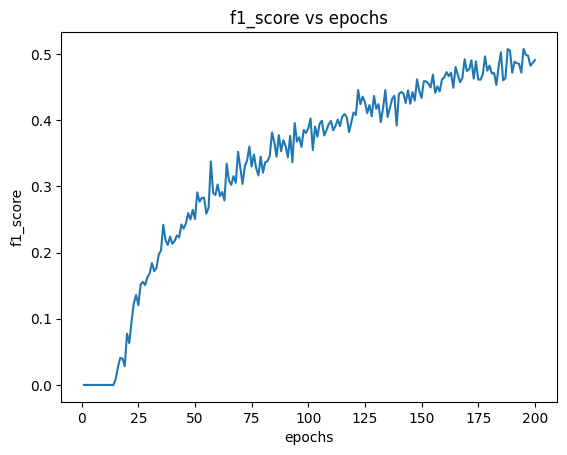

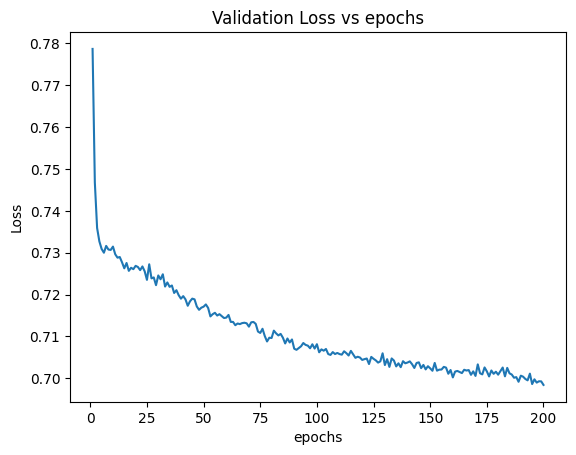

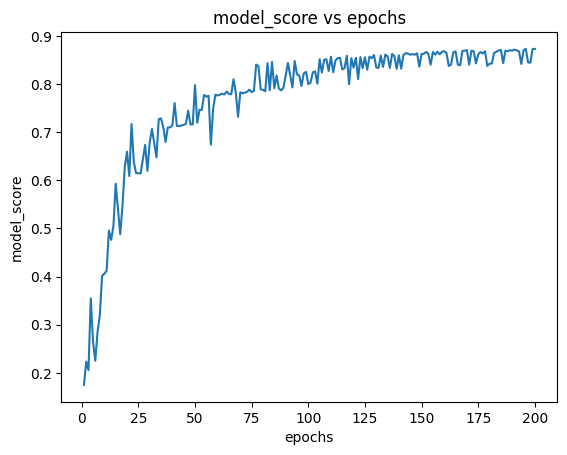

In [ ]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

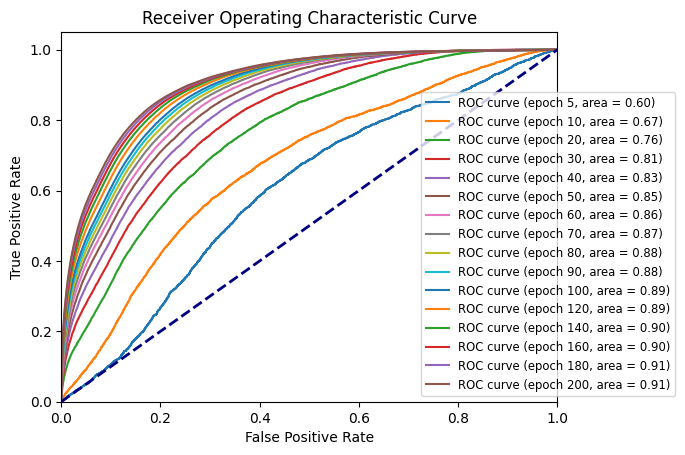

In [ ]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)